## STEP 1: INSTALLATION & IMPORTS

In [1]:
# --- 1. Installation ---
# Cài đặt tất cả các thư viện cần thiết.
# -qU: quiet (im lặng), upgrade (nâng cấp)
print("Bắt đầu cài đặt các thư viện...")
!pip install -qU langgraph langchain langchain-core langchain-community groq python-dotenv rich

Bắt đầu cài đặt các thư viện...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bi

In [28]:
!pip install -qU tavily-python google-api-python-client google-auth-oauthlib
print("Đã cài đặt các thư viện công cụ cần thiết.")

/usr/lib/python3.11/pathlib.py:540: RuntimeWarning: coroutine 'test_coordinator' was never awaited
  return self._str


Đã cài đặt các thư viện công cụ cần thiết.


In [29]:
!pip install google-auth-httplib2

In [1]:
# --- 2. Core Imports ---
# Import các thư viện và lớp (class) cốt lõi sẽ được sử dụng trong toàn bộ dự án.
import os
import json
from typing import TypedDict, Annotated, List, Dict, Any
import operator
from google.colab import userdata

# LangChain & LangGraph core components
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END, START

# Groq client for LLM interaction
from groq import AsyncGroq

# Rich library for beautiful printing
from rich.console import Console
from rich.markdown import Markdown

print("\nCài đặt và Import hoàn tất. Môi trường đã sẵn sàng!")


Cài đặt và Import hoàn tất. Môi trường đã sẵn sàng!


## STEP 2: STATE DEFINITION & LLM WRAPPER

In [19]:
# --- 1. State Definition ---
# Định nghĩa cấu trúc cho "bộ nhớ" chung của hệ thống.
# TypedDict giúp chúng ta xác định rõ ràng các trường dữ liệu và kiểu của chúng.
# Điều này giúp code dễ đọc, dễ bảo trì và tránh các lỗi gõ sai tên trường.

def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    """
    Hàm này dùng để hợp nhất (merge) hai dictionary một cách thông minh.
    Thay vì ghi đè, nó sẽ gộp các giá trị lồng nhau.
    Ví dụ: dict1 = {"a": {"x": 1}}, dict2 = {"a": {"y": 2}} -> {"a": {"x": 1, "y": 2}}
    LangGraph sẽ tự động sử dụng hàm này khi cập nhật trạng thái.
    """
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

class AcademicState(TypedDict):
    """
    Đây là "bộ nhớ" trung tâm (Master State) cho toàn bộ hệ thống ATLAS.
    Nó chứa tất cả thông tin mà các agent cần để làm việc và giao tiếp.
    """
    # Lịch sử cuộc trò chuyện giữa người dùng và hệ thống.
    messages: Annotated[List[BaseMessage], operator.add]

    # Thông tin hồ sơ của sinh viên.
    profile: Annotated[Dict, merge_dicts]

    # Thông tin lịch trình, các sự kiện.
    calendar: Annotated[Dict, merge_dicts]

    # Danh sách các công việc, bài tập cần làm.
    tasks: Annotated[Dict, merge_dicts]

    # Nơi lưu trữ kết quả đầu ra từ các agent sau mỗi bước.
    results: Annotated[Dict[str, Any], merge_dicts]

print("Đã định nghĩa 'AcademicState' thành công.")

Đã định nghĩa 'AcademicState' thành công.


In [20]:
# --- 2. LLM Wrapper ---
# Tạo một lớp (class) để bao bọc (wrap) việc giao tiếp với Groq API.
# Điều này giúp code của chúng ta sạch sẽ hơn. Thay vì viết code gọi API lặp đi lặp lại ở nhiều nơi,
# chúng ta chỉ cần gọi một phương thức đơn giản từ lớp này, ví dụ: llm.agenerate(...)

class GroqLLM:
    """
    Lớp này đóng vai trò là "người phiên dịch" giúp giao tiếp với Groq API.
    Nó sử dụng client bất đồng bộ (Async) để không làm block chương trình.
    """
    def __init__(self, api_key: str, model_name: str = "llama3-70b-8192"):
        self.model = model_name
        self.client = AsyncGroq(api_key=api_key)
        print(f"Khởi tạo GroqLLM thành công với model: {self.model}")

    async def agenerate(
        self,
        messages: List[Dict],
        temperature: float = 0.5,
        max_tokens: int = 2048
    ) -> str:
        """
        Gửi yêu cầu đến Groq và nhận lại câu trả lời dưới dạng văn bản.

        Args:
            messages: Danh sách tin nhắn theo định dạng [{ "role": "user", "content": "..." }].
            temperature: Độ "sáng tạo" của câu trả lời (0.0 - 1.0).
            max_tokens: Số lượng token tối đa cho câu trả lời.

        Returns:
            Nội dung câu trả lời của AI (dưới dạng string).
        """
        try:
            completion = await self.client.chat.completions.create(
                model=self.model,
                messages=messages,
                temperature=temperature,
                max_tokens=max_tokens,
                stream=False  # Chúng ta không cần stream cho ứng dụng này
            )
            return completion.choices[0].message.content
        except Exception as e:
            print(f"Lỗi khi gọi API của Groq: {e}")
            # Trả về một thông báo lỗi để hệ thống có thể xử lý
            return "Đã xảy ra lỗi khi cố gắng giao tiếp với mô hình ngôn ngữ."

In [21]:
# --- 3. Khởi tạo các đối tượng chính ---
# Bây giờ, chúng ta sẽ tạo ra các đối tượng mà toàn bộ hệ thống sẽ sử dụng.

# Lấy API key từ Colab Secrets
try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    # Khởi tạo đối tượng LLM
    llm = GroqLLM(api_key=GROQ_API_KEY)
except Exception as e:
    print(f"LỖI: Không thể lấy GROQ_API_KEY từ Colab Secrets. Hãy chắc chắn bạn đã lưu nó ở Bước 1.")
    print(f"Chi tiết lỗi: {e}")
    llm = None # Đặt llm là None nếu có lỗi

# Khởi tạo đối tượng Console để in ra màn hình cho đẹp
console = Console()

if llm:
    print("\nKhởi tạo đối tượng 'llm' và 'console' thành công. Hệ thống đã có 'bộ nhớ' và 'người phiên dịch'.")

Khởi tạo GroqLLM thành công với model: llama3-70b-8192

Khởi tạo đối tượng 'llm' và 'console' thành công. Hệ thống đã có 'bộ nhớ' và 'người phiên dịch'.


In [22]:
# GOOGLE AUTHENTICATION (PHIÊN BẢN SỬA LỖI CUỐI CÙNG CHO COLAB)

from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
import os

# THAY ĐỔI TÊN FILE NÀY cho khớp với tên file key của "robot" bạn đã tải về
SERVICE_ACCOUNT_FILE = 'credentials.json' # Hoặc tên file key của bạn, ví dụ: 'atlas-robot-key.json'

def authenticate_google_calendar_service_account():
    """Xác thực bằng Service Account, không cần tương tác của người dùng."""
    try:
        # Kiểm tra file có tồn tại không
        if not os.path.exists(SERVICE_ACCOUNT_FILE):
            print(f"LỖI: Không tìm thấy file key '{SERVICE_ACCOUNT_FILE}'. Hãy tải nó lên Colab.")
            return None

        SCOPES = ['https://www.googleapis.com/auth/calendar.readonly']
        creds = Credentials.from_service_account_file(
                SERVICE_ACCOUNT_FILE, scopes=SCOPES)
        service = build('calendar', 'v3', credentials=creds)
        print("✅ Xác thực Google Calendar bằng Service Account thành công.")
        return service
    except Exception as e:
        print(f"Lỗi khi xác thực bằng Service Account: {e}")
        return None

# Tải file key của Service Account lên trước khi chạy dòng này
# Đổi tên file key bạn tải về thành tên đã khai báo ở trên
google_calendar_service = authenticate_google_calendar_service_account()

✅ Xác thực Google Calendar bằng Service Account thành công.


## STEP 3: DATA MANAGER

In [23]:
# STEP 3 (Nâng cấp với Google Calendar): DATA MANAGER
import json
from datetime import datetime, timezone, timedelta
from typing import List, Dict, Optional

class DataManager:
    """
    Quản lý việc truy cập dữ liệu. Giờ đây đọc lịch trực tiếp từ Google Calendar.
    """
    def __init__(self, gcal_service):
        self.profile_data: Optional[Dict] = None
        self.task_data: Optional[Dict] = None
        # Nhận đối tượng service đã được xác thực
        self.gcal_service = gcal_service
        print("DataManager (Google Calendar Edition) đã được khởi tạo.")

    def load_static_data(self, profile_path: str, task_path: str):
        """
        Tải dữ liệu tĩnh (không thay đổi thường xuyên) từ các file JSON.
        Lưu ý: Không còn tải calendar.json nữa.
        """
        try:
            with open(profile_path, 'r', encoding='utf-8') as f:
                self.profile_data = json.load(f)
            with open(task_path, 'r', encoding='utf-8') as f:
                self.task_data = json.load(f)
            print("Đã tải thành công dữ liệu tĩnh (profile, tasks).")
            return True
        except FileNotFoundError as e:
            print(f"LỖI: Không tìm thấy file - {e}.")
            return False
        except json.JSONDecodeError as e:
            print(f"LỖI: File JSON không hợp lệ - {e}.")
            return False

    def get_student_profile(self, student_id: str) -> Optional[Dict]:
        if not self.profile_data:
            return None
        return next((p for p in self.profile_data.get("profiles", []) if p.get("id") == student_id), None)

    def _parse_datetime(self, dt_str: str) -> datetime:
        if dt_str.endswith('Z'):
            dt_str = dt_str[:-1] + '+00:00'
        return datetime.fromisoformat(dt_str).astimezone(timezone.utc)

    def get_upcoming_events(self, days_ahead: int = 14) -> List[Dict]:
        """
        Lấy danh sách sự kiện sắp tới trực tiếp từ Google Calendar API.
        """
        if not self.gcal_service:
            print("Lỗi: Dịch vụ Google Calendar không có sẵn.")
            return []

        print(f"\n🗓️  Đang truy vấn Google Calendar cho {days_ahead} ngày tới...")
        now_utc = datetime.now(timezone.utc).isoformat()
        future_limit = (datetime.now(timezone.utc) + timedelta(days=days_ahead)).isoformat()

        try:
            events_result = self.gcal_service.events().list(
                calendarId='td.tan2711@gmail.com',
                timeMin=now_utc,
                timeMax=future_limit,
                singleEvents=True,
                orderBy='startTime'
            ).execute()
            events = events_result.get('items', [])
            print(f"✅ Tìm thấy {len(events)} sự kiện sắp tới.")
            return events
        except Exception as e:
            print(f"Lỗi khi gọi Google Calendar API: {e}")
            return []

    def get_active_tasks(self) -> List[Dict]:
        if not self.task_data:
            return []
        now_utc = datetime.now(timezone.utc)
        active_tasks = []
        for task in self.task_data.get("tasks", []):
            try:
                due_str = task.get("due")
                if task.get("status") == "needsAction" and due_str:
                    due_date = self._parse_datetime(due_str)
                    if due_date > now_utc:
                        active_tasks.append(task)
            except (ValueError, KeyError) as e:
                print(f"Warning: Bỏ qua task bị lỗi định dạng - {task.get('title', 'N/A')}. Lỗi: {e}")
                continue
        return sorted(active_tasks, key=lambda t: self._parse_datetime(t['due']))

# --- Thử nghiệm DataManager phiên bản mới ---
if 'google_calendar_service' in locals() and google_calendar_service:
    data_manager = DataManager(gcal_service=google_calendar_service)
    is_loaded = data_manager.load_static_data(profile_path="profile.json", task_path="tasks.json")

    if is_loaded:
        upcoming_events_from_google = data_manager.get_upcoming_events()
        # Đảm bảo console đã được khởi tạo ở STEP 2
        if 'console' in locals():
            console.print("\n[bold green]Các sự kiện sắp tới từ Google Calendar:[/bold green]")
            console.print(upcoming_events_from_google)
        else:
            print("\nCác sự kiện sắp tới từ Google Calendar:")
            print(upcoming_events_from_google)
else:
    # Đảm bảo console đã được khởi tạo ở STEP 2
    if 'console' in locals():
      console.print("[bold red]Bỏ qua thử nghiệm DataManager vì xác thực Google thất bại hoặc chưa được chạy.[/bold red]")
    else:
      print("Bỏ qua thử nghiệm DataManager vì xác thực Google thất bại hoặc chưa được chạy.")

DataManager (Google Calendar Edition) đã được khởi tạo.
Đã tải thành công dữ liệu tĩnh (profile, tasks).

🗓️  Đang truy vấn Google Calendar cho 14 ngày tới...
✅ Tìm thấy 4 sự kiện sắp tới.


Các sự kiện sắp tới từ Google Calendar:

[
    {
        'kind': 'calendar#event',
        'etag': '"3508081149152766"',
        'id': '11l2dmaa8pngqeriod2e4mkn9f',
        'status': 'confirmed',
        'htmlLink': 
'https://www.google.com/calendar/event?eid=MTFsMmRtYWE4cG5ncWVyaW9kMmU0bWtuOWYgdGQudGFuMjcxMUBt',
        'created': '2025-08-01T08:59:53.000Z',
        'updated': '2025-08-01T09:29:34.576Z',
        'summary': 'Finish LangGraph project',
        'creator': {'email': 'td.tan2711@gmail.com', 'self': True},
        'organizer': {'email': 'td.tan2711@gmail.com', 'self': True},
        'start': {'dateTime': '2025-08-03T02:00:00+07:00', 'timeZone': 'Asia/Ho_Chi_Minh'},
        'end': {'dateTime': '2025-08-03T05:00:00+07:00', 'timeZone': 'Asia/Ho_Chi_Minh'},
        'iCalUID': '11l2dmaa8pngqeriod2e4mkn9f@google.com',
        'sequence': 0,
        'reminders': {'useDefault': True},
        'eventType': 'default'
    },
    {
        'kind': 'calendar#event',
        'etag': '"3508081069952958"',
        'id': '6l7ltb61hlduad6bukb6s29s9p',
        'status': 'confirmed',
        'htmlLink': 
'https://www.google.com/calendar/event?eid=Nmw3bHRiNjFobGR1YWQ2YnVrYjZzMjlzOXAgdGQudGFuMjcxMUBt',
        'created': '2025-08-01T09:28:54.000Z',
        'updated': '2025-08-01T09:28:54.976Z',
        'summary': 'Have an important Math exam',
        'creator': {'email': 'td.tan2711@gmail.com', 'self': True},
        'organizer': {'email': 'td.tan2711@gmail.com', 'self': True},
        'start': {'dateTime': '2025-08-04T15:15:00+07:00', 'timeZone': 'Asia/Ho_Chi_Minh'},
        'end': {'dateTime': '2025-08-04T20:00:00+07:00', 'timeZone': 'Asia/Ho_Chi_Minh'},
        'iCalUID': '6l7ltb61hlduad6bukb6s29s9p@google.com',
        'sequence': 0,
        'reminders': {'useDefault': True},
        'eventType': 'default'
    },
    {
        'kind': 'calendar#event',
        'etag': '"3508081125082238"',
        'id': '7a3is4qvunvl2jh8ndv74je0c7',
        'status': 'confirmed',
        'htmlLink': 
'https://www.google.com/calendar/event?eid=N2EzaXM0cXZ1bnZsMmpoOG5kdjc0amUwYzcgdGQudGFuMjcxMUBt',
        'created': '2025-08-01T08:58:54.000Z',
        'updated': '2025-08-01T09:29:22.541Z',
        'summary': 'Research for AI in Education',
        'creator': {'email': 'td.tan2711@gmail.com', 'self': True},
        'organizer': {'email': 'td.tan2711@gmail.com', 'self': True},
        'start': {'dateTime': '2025-08-06T04:30:00+07:00', 'timeZone': 'Asia/Ho_Chi_Minh'},
        'end': {'dateTime': '2025-08-06T08:00:00+07:00', 'timeZone': 'Asia/Ho_Chi_Minh'},
        'iCalUID': '7a3is4qvunvl2jh8ndv74je0c7@google.com',
        'sequence': 0,
        'reminders': {'useDefault': True},
        'eventType': 'default'
    },
    {
        'kind': 'calendar#event',
        'etag': '"3508081097820894"',
        'id': '3ljo26aunuvvmqoe61qa81m591',
        'status': 'confirmed',
        'htmlLink': 
'https://www.google.com/calendar/event?eid=M2xqbzI2YXVudXZ2bXFvZTYxcWE4MW01OTEgdGQudGFuMjcxMUBt',
        'created': '2025-08-01T08:59:32.000Z',
        'updated': '2025-08-01T09:29:08.910Z',
        'summary': 'Work Online',
        'creator': {'email': 'td.tan2711@gmail.com', 'self': True},
        'organizer': {'email': 'td.tan2711@gmail.com', 'self': True},
        'start': {'dateTime': '2025-08-08T19:45:00+07:00', 'timeZone': 'Asia/Ho_Chi_Minh'},
        'end': {'dateTime': '2025-08-08T21:15:00+07:00', 'timeZone': 'Asia/Ho_Chi_Minh'},
        'iCalUID': '3ljo26aunuvvmqoe61qa81m591@google.com',
        'sequence': 0,
        'reminders': {'useDefault': True},
        'eventType': 'default'
    }
]

## STEP 4: THE COORDINATOR AGENT
#### Đây là agent đầu tiên và quan trọng nhất, đóng vai trò điều phối.
#### Nó không thực hiện các tác vụ cụ thể như lập kế hoạch hay viết ghi chú,
#### mà thay vào đó, nó phân tích yêu cầu của người dùng để quyết định
#### agent chuyên biệt nào cần được kích hoạt.

In [24]:
import asyncio
from typing import Dict, Any, List

# --- 1. Hàm trợ giúp: Phân tích bối cảnh (analyze_context) ---
# Hàm này thu thập tất cả thông tin liên quan từ trạng thái (state)
# và gói gọn chúng lại để gửi cho LLM.
async def analyze_context(state: AcademicState) -> Dict[str, Any]:
    """
    Phân tích trạng thái hiện tại để tạo ra một bản tóm tắt bối cảnh.
    Bản tóm tắt này giúp LLM hiểu rõ tình hình của sinh viên.
    """
    profile = state.get("profile", {})
    # Sử dụng .get() để tránh lỗi nếu một key nào đó không tồn tại.
    context = {
        "student_major": profile.get("personal_info", {}).get("major", "N/A"),
        "academic_year": profile.get("personal_info", {}).get("academic_year", "N/A"),
        "learning_style": profile.get("learning_preferences", {}).get("learning_style", {}).get("type", "N/A"),
        "preferred_study_time": profile.get("learning_preferences", {}).get("study_patterns", {}).get("best_time", "N/A"),
        "num_upcoming_events": len(state.get("calendar", {}).get("events", [])),
        "num_active_tasks": len(state.get("tasks", {}).get("tasks", []))
    }
    return context

In [25]:
# --- 2. Prompt cho Coordinator Agent ---
# Prompt là "bộ não" của agent. Một prompt tốt sẽ hướng dẫn LLM
# suy nghĩ và trả lời theo đúng cách chúng ta muốn.
COORDINATOR_PROMPT = """
Bạn là một Coordinator Agent bậc thầy trong hệ thống hỗ trợ học tập ATLAS.
Nhiệm vụ của bạn KHÔNG phải là trả lời trực tiếp yêu cầu của người dùng, mà là phân tích yêu cầu đó và quyết định agent nào cần được kích hoạt để xử lý.

CÁC AGENT CÓ SẴN:
- PLANNER: Chuyên gia lập kế hoạch, quản lý lịch trình và công việc. Kích hoạt khi yêu cầu liên quan đến lịch, thời gian, deadline, tạo kế hoạch.
- NOTEWRITER: Chuyên gia tạo ghi chú, tóm tắt tài liệu, bài giảng. Kích hoạt khi yêu cầu liên quan đến việc tạo tài liệu học tập, tóm tắt, ghi chú.
- ADVISOR: Chuyên gia tư vấn chiến lược học tập, đưa ra lời khuyên. Kích hoạt khi yêu cầu cần lời khuyên về phương pháp học, cách đối mặt với khó khăn.

BỐI CẢNH HIỆN TẠI CỦA SINH VIÊN:
{context}

YÊU CẦU CỦA SINH VIÊN:
"{request}"

DỰA VÀO BỐI CẢNH VÀ YÊU CẦU, hãy thực hiện các bước sau:
1.  **Reasoning (Lý luận):** Suy nghĩ từng bước để phân tích yêu cầu. Người dùng thực sự cần gì? Vấn đề cốt lõi là gì?
2.  **Decision (Quyết định):** Dựa trên lý luận, quyết định danh sách các agent cần thiết.

HÃY TRẢ LỜI THEO ĐỊNH DẠNG JSON CHÍNH XÁC NHƯ SAU, KHÔNG THÊM BẤT KỲ GIẢI THÍCH NÀO KHÁC:
{{
  "reasoning": "...",
  "required_agents": ["AGENT_1", "AGENT_2", ...]
}}
"""

In [26]:
# --- 3. Hàm trợ giúp: Phân tích phản hồi của AI (parse_coordinator_response) ---
# Hàm này lấy chuỗi JSON trả về từ LLM và chuyển nó thành một dictionary Python.
def parse_coordinator_response(response_str: str) -> Dict[str, Any]:
    """
    Phân tích chuỗi trả lời của LLM để lấy ra thông tin có cấu trúc.
    Có xử lý lỗi nếu LLM trả về không đúng định dạng JSON.
    """
    try:
        # Tìm và trích xuất nội dung JSON từ trong chuỗi
        json_match = response_str[response_str.find('{'):response_str.rfind('}')+1]
        parsed_json = json.loads(json_match)
        # Đảm bảo key 'required_agents' luôn tồn tại và là một list
        if "required_agents" not in parsed_json or not isinstance(parsed_json["required_agents"], list):
            parsed_json["required_agents"] = ["PLANNER"] # Mặc định là PLANNER nếu có lỗi
        return parsed_json
    except (json.JSONDecodeError, IndexError):
        print("Warning: Không thể phân tích phản hồi từ Coordinator. Sử dụng agent mặc định là PLANNER.")
        # Nếu có lỗi, trả về một cấu trúc mặc định an toàn
        return {
            "reasoning": "Lỗi phân tích phản hồi. Mặc định kích hoạt Planner.",
            "required_agents": ["PLANNER"]
        }

In [27]:
# --- 4. Hàm Agent chính: coordinator_agent ---
# Đây là hàm sẽ được đăng ký làm một "nút" (node) trong đồ thị LangGraph.
async def coordinator_agent(state: AcademicState) -> Dict[str, Any]:
    """
    Thực thi logic của Coordinator Agent.
    """
    print("\n--- Bắt đầu chạy Coordinator Agent ---")
    try:
        # 1. Thu thập bối cảnh
        context = await analyze_context(state)
        # 2. Lấy yêu cầu gần nhất của người dùng
        request = state["messages"][-1].content

        # 3. Tạo prompt hoàn chỉnh
        prompt = COORDINATOR_PROMPT.format(
            context=json.dumps(context, indent=2, ensure_ascii=False),
            request=request
        )

        # 4. Gửi yêu cầu đến LLM
        print("Gửi yêu cầu đến LLM để phân tích...")
        response_str = await llm.agenerate([
            {"role": "user", "content": prompt}
        ])
        print("Đã nhận phản hồi từ LLM.")
        console.print("[yellow]Phản hồi thô từ LLM:[/yellow]")
        console.print(response_str)

        # 5. Phân tích phản hồi
        analysis_result = parse_coordinator_response(response_str)
        print("Đã phân tích phản hồi thành công.")

        # 6. Trả về kết quả để cập nhật vào trạng thái chung
        # Kết quả sẽ được lưu vào state['results']['coordinator_analysis']
        return {
            "results": {
                "coordinator_analysis": analysis_result
            }
        }

    except Exception as e:
        print(f"LỖI nghiêm trọng trong Coordinator Agent: {e}")
        # Trong trường hợp có lỗi không lường trước, vẫn trả về một cấu trúc an toàn
        return {
            "results": {
                "coordinator_analysis": {
                    "reasoning": f"Lỗi hệ thống: {e}",
                    "required_agents": ["PLANNER"]
                }
            }
        }

In [28]:
# --- 5. Thử nghiệm Agent với Dữ liệu Live ---

async def test_coordinator_live():
    print("Bắt đầu thử nghiệm Coordinator Agent với dữ liệu live...")

    # 1. Lấy dữ liệu live từ DataManager
    # Điều này mô phỏng chính xác những gì sẽ xảy ra trong hệ thống đầy đủ
    live_calendar_events = data_manager.get_upcoming_events()
    live_active_tasks = data_manager.get_active_tasks()

    # 2. Tạo một yêu cầu chung chung hơn
    user_request = "Dựa vào lịch trình và công việc của tôi, hãy giúp tôi lập kế hoạch và tìm kiếm một số thông tin liên quan."

    # 3. Giả lập trạng thái ban đầu với dữ liệu live
    initial_state = {
        "messages": [HumanMessage(content=user_request)],
        "profile": data_manager.get_student_profile("student_123"),
        "calendar": {"events": live_calendar_events}, # <-- Dữ liệu thật
        "tasks": {"tasks": live_active_tasks},       # <-- Dữ liệu thật
        "results": {}
    }

    # 4. Chạy coordinator_agent với trạng thái live
    coordinator_result = await coordinator_agent(initial_state)

    # In kết quả phân tích ra màn hình
    console.print("\n--- KẾT QUẢ PHÂN TÍCH CỦA COORDINATOR (DỮ LIỆU LIVE) ---")
    console.print(coordinator_result['results']['coordinator_analysis'])


# Chỉ chạy nếu llm và data_manager đã được khởi tạo thành công
if 'llm' in locals() and 'data_manager' in locals() and data_manager:
    await test_coordinator_live()
else:
    console.print("[bold red]Bỏ qua thử nghiệm vì 'llm' hoặc 'data_manager' chưa được khởi tạo.[/bold red]")

Bắt đầu thử nghiệm Coordinator Agent với dữ liệu live...

🗓️  Đang truy vấn Google Calendar cho 14 ngày tới...
✅ Tìm thấy 4 sự kiện sắp tới.

--- Bắt đầu chạy Coordinator Agent ---
Gửi yêu cầu đến LLM để phân tích...
Đã nhận phản hồi từ LLM.


Phản hồi thô từ LLM:

{
  "reasoning": "The student is asking for help with planning and finding related information based on their 
schedule and tasks. The core issue is that the student needs to manage their time and tasks effectively. The 
student's request implies that they need assistance with prioritizing tasks, allocating time, and possibly finding 
relevant resources.",
  "required_agents": ["PLANNER"]
}

Đã phân tích phản hồi thành công.


--- KẾT QUẢ PHÂN TÍCH CỦA COORDINATOR (DỮ LIỆU LIVE) ---

{
    'reasoning': "The student is asking for help with planning and finding related information based on their 
schedule and tasks. The core issue is that the student needs to manage their time and tasks effectively. The 
student's request implies that they need assistance with prioritizing tasks, allocating time, and possibly finding 
relevant resources.",
    'required_agents': ['PLANNER']
}

## STEP 5: THE PLANNER AGENT
#### Nó chứa một quy trình làm việc nội bộ (subgraph) để thực hiện các tác vụ phức tạp.

In [29]:
# --- 1. Định nghĩa Lớp PlannerAgent ---
class PlannerAgent:
    """
    Agent chuyên xử lý mọi thứ liên quan đến lập kế hoạch, lịch trình và công việc.
    """
    def __init__(self, llm_instance: GroqLLM):
        """Khởi tạo agent với một instance của LLM."""
        self.llm = llm_instance
        print("PlannerAgent đã được khởi tạo.")

    async def calendar_analyzer(self, state: AcademicState) -> Dict[str, Any]:
        """
        Nút đầu tiên trong subgraph của Planner: Phân tích lịch trình.
        """
        print("\n--- [Planner] Bắt đầu phân tích Lịch trình (calendar_analyzer) ---")
        # Lấy dữ liệu cần thiết từ trạng thái
        events = state["calendar"].get("events", [])
        request = state["messages"][-1].content

        prompt = f"""
        Bạn là một trợ lý phân tích lịch trình. Dựa vào danh sách các sự kiện dưới đây và yêu cầu của người dùng, hãy đưa ra một bản phân tích ngắn gọn.

        YÊU CẦU NGƯỜI DÙNG: "{request}"

        DANH SÁCH SỰ KIỆN:
        {json.dumps(events, indent=2, ensure_ascii=False)}

        HÃY PHÂN TÍCH VÀ TRẢ LỜI:
        - Các khoảng thời gian trống chính.
        - Các xung đột tiềm tàng hoặc những ngày bận rộn.
        - Mức độ áp lực về lịch trình (cao, trung bình, thấp).
        """
        response = await self.llm.agenerate([{"role": "user", "content": prompt}])
        console.print("[cyan]Phân tích lịch trình:[/cyan]", response)

        # Trả về kết quả để hợp nhất vào state['results']['calendar_analysis']
        return {"results": {"calendar_analysis": {"analysis_text": response}}}


    async def task_analyzer(self, state: AcademicState) -> Dict[str, Any]:
        """
        Nút thứ hai trong subgraph của Planner: Phân tích công việc.
        """
        print("\n--- [Planner] Bắt đầu phân tích Công việc (task_analyzer) ---")
        tasks = state["tasks"].get("tasks", [])
        request = state["messages"][-1].content

        prompt = f"""
        Bạn là một trợ lý phân tích công việc. Dựa vào danh sách công việc và yêu cầu của người dùng, hãy đưa ra một bản phân tích ngắn gọn.

        YÊU CẦU NGƯỜI DÙNG: "{request}"

        DANH SÁCH CÔNG VIỆC:
        {json.dumps(tasks, indent=2, ensure_ascii=False)}

        HÃY PHÂN TÍCH VÀ TRẢ LỜI:
        - Công việc nào cần được ưu tiên nhất và tại sao.
        - Mức độ áp lực về công việc (cao, trung bình, thấp).
        - Các deadline gần nhất cần chú ý.
        """
        response = await self.llm.agenerate([{"role": "user", "content": prompt}])
        console.print("[cyan]Phân tích công việc:[/cyan]", response)
        return {"results": {"task_analysis": {"analysis_text": response}}}


    async def plan_generator(self, state: AcademicState) -> Dict[str, Any]:
        """
        Nút cuối cùng: Tổng hợp tất cả các phân tích để tạo ra kế hoạch cuối cùng.
        """
        print("\n--- [Planner] Bắt đầu tạo Kế hoạch (plan_generator) ---")
        # Thu thập tất cả các "nguyên liệu"
        request = state["messages"][-1].content
        profile = state.get("profile", {})
        calendar_analysis = state.get("results", {}).get("calendar_analysis", "Không có phân tích lịch trình.")
        task_analysis = state.get("results", {}).get("task_analysis", "Không có phân tích công việc.")

        prompt = f"""
        Bạn là một chuyên gia lập kế hoạch học tập siêu hạng. Nhiệm vụ của bạn là tạo ra một bản kế hoạch CHI TIẾT và DỄ THỰC HIỆN cho sinh viên.

        DỰA VÀO TẤT CẢ CÁC THÔNG TIN DƯỚI ĐÂY:

        1.  **YÊU CẦU CỦA SINH VIÊN:**
            "{request}"

        2.  **HỒ SƠ SINH VIÊN:**
            {json.dumps(profile, indent=2, ensure_ascii=False)}

        3.  **PHÂN TÍCH LỊCH TRÌNH CỦA BẠN:**
            {json.dumps(calendar_analysis, indent=2, ensure_ascii=False)}

        4.  **PHÂN TÍCH CÔNG VIỆC CỦA BẠN:**
            {json.dumps(task_analysis, indent=2, ensure_ascii=False)}

        HÃY TẠO RA MỘT BẢN KẾ HOẠCH HOÀN CHỈNH. Bản kế hoạch nên bao gồm:
        - Một lịch trình gợi ý theo từng ngày hoặc buổi.
        - Các chiến lược cụ thể để giải quyết công việc.
        - Lời khuyên về việc cân bằng giữa học tập và các hoạt động khác.
        - Sử dụng giọng văn thân thiện, động viên.
        """
        response = await self.llm.agenerate([{"role": "user", "content": prompt}], temperature=0.7)
        console.print("[bold green]Kế hoạch cuối cùng đã được tạo:[/bold green]")
        console.print(Markdown(response))
        return {"results": {"final_plan": {"plan_text": response}}}


    def create_subgraph(self) -> StateGraph:
        """
        Tạo và trả về đồ thị con (subgraph) cho riêng PlannerAgent.
        """
        subgraph = StateGraph(AcademicState)
        subgraph.add_node("calendar_analyzer", self.calendar_analyzer)
        subgraph.add_node("task_analyzer", self.task_analyzer)
        subgraph.add_node("plan_generator", self.plan_generator)

        # Định nghĩa luồng đi: analyzer -> task_analyzer -> plan_generator
        subgraph.add_edge("calendar_analyzer", "task_analyzer")
        subgraph.add_edge("task_analyzer", "plan_generator")

        # Điểm bắt đầu của subgraph này là calendar_analyzer
        subgraph.set_entry_point("calendar_analyzer")
        # Điểm kết thúc là plan_generator (sau khi chạy xong sẽ tự động kết thúc)
        subgraph.add_edge("plan_generator", END)

        return subgraph.compile()


In [30]:
# --- 2. Thử nghiệm PlannerAgent ---
async def test_planner_agent():
    # Khởi tạo Planner Agent
    planner = PlannerAgent(llm)
    # Tạo subgraph của nó
    planner_workflow = planner.create_subgraph()

    # Giả lập một trạng thái ban đầu (như là đã chạy qua Coordinator)
    initial_state_for_planner = {
        "messages": [HumanMessage(content="Tôi có một bài tập lớn AI sắp hết hạn và một kỳ thi vào tuần tới. Hãy giúp tôi tạo một kế hoạch chi tiết.")],
        "profile": data_manager.get_student_profile("student_123"),
        "calendar": {"events": data_manager.get_upcoming_events()},
        "tasks": {"tasks": data_manager.get_active_tasks()},
        "results": {
            # Giả sử Coordinator đã chạy và đưa ra kết quả này
            "coordinator_analysis": {
                "reasoning": "Yêu cầu cần một kế hoạch chi tiết.",
                "required_agents": ["PLANNER"]
            }
        }
    }

    print("\n--- BẮT ĐẦU THỬ NGHIỆM PLANNER AGENT SUBGRAPH ---")
    # Chạy toàn bộ workflow của Planner
    final_planner_state = await planner_workflow.ainvoke(initial_state_for_planner)

    console.print("\n--- KẾT QUẢ CUỐI CÙNG TỪ PLANNER AGENT ---")
    # In ra kế hoạch cuối cùng từ trạng thái kết quả
    console.print(Markdown(final_planner_state['results']['final_plan']['plan_text']))


# Chạy hàm test nếu llm đã được khởi tạo
if llm:
    await test_planner_agent()
else:
    console.print("[bold red]Bỏ qua thử nghiệm vì đối tượng 'llm' chưa được khởi tạo.[/bold red]")

PlannerAgent đã được khởi tạo.

🗓️  Đang truy vấn Google Calendar cho 14 ngày tới...
✅ Tìm thấy 4 sự kiện sắp tới.

--- BẮT ĐẦU THỬ NGHIỆM PLANNER AGENT SUBGRAPH ---

--- [Planner] Bắt đầu phân tích Lịch trình (calendar_analyzer) ---


Phân tích lịch trình: Based on the provided calendar events, here is a brief analysis:

**Available time slots:**

* August 1-2: No events scheduled
* August 5: No events scheduled
* August 7: No events scheduled
* August 8 (before 19:45): No events scheduled

**Potential conflicts or busy days:**

* August 3: Finish LangGraph project (02:00-05:00) - may impact other activities
* August 4: Math exam (15:15-20:00) - high priority event
* August 6: Research for AI in Education (04:30-08:00) - may impact other activities

**Schedule pressure level:**

* High: August 3-4 (multiple high-priority events)
* Medium: August 6 (research event may impact other activities)
* Low: August 1-2, 5, 7, 8 (no events or low-priority events)

To create a detailed plan, I recommend allocating dedicated time for the AI project and Math exam preparation, 
while also leaving some buffer time for unexpected tasks or breaks. Additionally, consider prioritizing tasks based
on their importance and deadlines to ensure a smooth and manageable schedule.


--- [Planner] Bắt đầu phân tích Công việc (task_analyzer) ---


Phân tích công việc: Based on the provided task list and user requirements, here is a brief analysis:

**Priority Task:** "Submit AI project report" (task_01) with a high priority. This task has a nearing deadline 
(2025-08-10T23:59:00Z) and is critical for the user's AI project, which is likely a significant academic or 
professional commitment.

**Workload Pressure:** High. The user has two tasks with nearing deadlines, and one of them is high-priority. This 
suggests that the user needs to focus their attention on these tasks to meet the deadlines and avoid last-minute 
rushes or potential penalties.

**Upcoming Deadlines:** The user needs to pay attention to the following deadlines:

* 2025-08-08T23:59:00Z: Deadline for "Read Chapter 5 - Operating Systems" (task_02)
* 2025-08-10T23:59:00Z: Deadline for "Submit AI project report" (task_01)

To create a detailed plan, I recommend the following:

1. Allocate dedicated time for the high-priority task "Submit AI project report" to ensure its completion before 
the deadline.
2. Schedule time for "Read Chapter 5 - Operating Systems" to avoid procrastination and meet the deadline.
3. Consider allocating additional time for reviewing and preparing for the upcoming exam, as it is mentioned in the
user's request but not included in the task list.

By prioritizing the AI project report and managing time effectively, the user can reduce workload pressure and feel
more confident in meeting their deadlines.


--- [Planner] Bắt đầu tạo Kế hoạch (plan_generator) ---


Kế hoạch cuối cùng đã được tạo:

Customized Study Plan for An Nguyen                                                                                

Hey An!                                                                                                            

I've created a tailored study plan to help you tackle your AI project and prepare for your upcoming exam. This plan
is designed to fit your learning style, schedule, and priorities.                                                  

Available Time Slots:                                                                                              

 • August 1-2: No events scheduled                                                                                 
 • August 5: No events scheduled                                                                                   
 • August 7: No events scheduled                                                                                   
 • August 8 (before 19:45): No events scheduled                                                                    

Recommended Study Schedule:                                                                                        

August 1-2: AI Project Focus                                                                                       

 • 9:00 AM - 12:00 PM: Work on AI project report (task_01)                                                         
    • Breakdown the task into smaller chunks, and create a mind map to visualize your progress.                    
    • Use diagrams and videos to help you understand complex concepts.                                             
 • 15-minute breaks every 45 minutes to refresh your mind.                                                         

August 3: Math Exam Prep                                                                                           

 • 9:00 AM - 12:00 PM: Review Math notes and practice problems                                                     
    • Focus on chapters related to the upcoming exam.                                                              
    • Use flashcards or concept maps to reinforce your understanding.                                              
 • 15-minute breaks every 45 minutes to refresh your mind.                                                         

August 4: Math Exam                                                                                                

 • 15:15-20:00: Take the Math exam                                                                                 

August 5: AI Project Focus                                                                                         

 • 9:00 AM - 12:00 PM: Work on AI project report (task_01)                                                         
    • Continue working on the project report, focusing on the most critical sections.                              
    • Use visual aids to help you organize your thoughts and ideas.                                                
 • 15-minute breaks every 45 minutes to refresh your mind.                                                         

August 6: Research and Review                                                                                      

 • 9:00 AM - 12:00 PM: Research for AI in Education (task_03)                                                      
    • Take notes and organize your thoughts using diagrams or mind maps.                                           
    • Review what you've learned so far and connect it to your AI project.                                         
 • 15-minute breaks every 45 minutes to refresh your mind.                                                         

August 7: Exam Prep and Review                                                                                     

 • 9:00 AM - 12:00 PM: Review AI project report and notes                                                          
    • Go through your project report an

--- KẾT QUẢ CUỐI CÙNG TỪ PLANNER AGENT ---

Customized Study Plan for An Nguyen                                                                                

Hey An!                                                                                                            

I've created a tailored study plan to help you tackle your AI project and prepare for your upcoming exam. This plan
is designed to fit your learning style, schedule, and priorities.                                                  

Available Time Slots:                                                                                              

 • August 1-2: No events scheduled                                                                                 
 • August 5: No events scheduled                                                                                   
 • August 7: No events scheduled                                                                                   
 • August 8 (before 19:45): No events scheduled                                                                    

Recommended Study Schedule:                                                                                        

August 1-2: AI Project Focus                                                                                       

 • 9:00 AM - 12:00 PM: Work on AI project report (task_01)                                                         
    • Breakdown the task into smaller chunks, and create a mind map to visualize your progress.                    
    • Use diagrams and videos to help you understand complex concepts.                                             
 • 15-minute breaks every 45 minutes to refresh your mind.                                                         

August 3: Math Exam Prep                                                                                           

 • 9:00 AM - 12:00 PM: Review Math notes and practice problems                                                     
    • Focus on chapters related to the upcoming exam.                                                              
    • Use flashcards or concept maps to reinforce your understanding.                                              
 • 15-minute breaks every 45 minutes to refresh your mind.                                                         

August 4: Math Exam                                                                                                

 • 15:15-20:00: Take the Math exam                                                                                 

August 5: AI Project Focus                                                                                         

 • 9:00 AM - 12:00 PM: Work on AI project report (task_01)                                                         
    • Continue working on the project report, focusing on the most critical sections.                              
    • Use visual aids to help you organize your thoughts and ideas.                                                
 • 15-minute breaks every 45 minutes to refresh your mind.                                                         

August 6: Research and Review                                                                                      

 • 9:00 AM - 12:00 PM: Research for AI in Education (task_03)                                                      
    • Take notes and organize your thoughts using diagrams or mind maps.                                           
    • Review what you've learned so far and connect it to your AI project.                                         
 • 15-minute breaks every 45 minutes to refresh your mind.                                                         

August 7: Exam Prep and Review                                                                                     

 • 9:00 AM - 12:00 PM: Review AI project report and notes                                                          
    • Go through your project report an

## STEP 6: THE NOTEWRITER AGENT
#### Agent này chuyên về việc xử lý nội dung, tạo ghi chú và tóm tắt tài liệu.
#### Nó cũng có một subgraph nội bộ riêng

In [31]:
# STEP 6 (Nâng cấp với Tavily): THE NOTEWRITER AGENT (PHIÊN BẢN NHÀ NGHIÊN CỨU THỰC THỤ)
import tavily

# --- 1. Tạo Công cụ Tìm kiếm Tavily ---
class TavilySearchTool:
    """
    Một lớp bao bọc (wrapper) cho Tavily API để thực hiện tìm kiếm.
    """
    def __init__(self, api_key: str):
        self.client = tavily.TavilyClient(api_key=api_key)
        print("Khởi tạo TavilySearchTool thành công.")

    def search(self, queries: List[str], max_results: int = 3) -> Dict[str, str]:
        """
        Thực hiện tìm kiếm cho mỗi truy vấn và trả về nội dung đã được xử lý.
        """
        print(f"\n🔎 [Tavily Tool] Đang thực hiện tìm kiếm với các truy vấn: {queries}")
        all_results = {}
        try:
            for query in queries:
                # search_depth="advanced" giúp Tavily trả về kết quả sâu hơn
                response = self.client.search(query=query, search_depth="advanced", max_results=max_results)
                # Ghép nối nội dung từ các kết quả trả về
                combined_content = "\n\n".join([res["content"] for res in response["results"]])
                all_results[query] = combined_content
            print("✅ [Tavily Tool] Tìm kiếm hoàn tất.")
            return all_results
        except Exception as e:
            print(f"Lỗi khi tìm kiếm với Tavily: {e}")
            return {"error": "Không thể thực hiện tìm kiếm."}





In [32]:
# --- 2. Khởi tạo công cụ Tavily ---
try:
    TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
    tavily_tool = TavilySearchTool(api_key=TAVILY_API_KEY)
except Exception as e:
    print(f"LỖI: Không thể lấy TAVILY_API_KEY. Hãy chắc chắn bạn đã lưu nó.")
    tavily_tool = None

Khởi tạo TavilySearchTool thành công.


In [33]:
# --- 3. Định nghĩa Lớp NoteWriterAgent (sử dụng Tavily) ---
class NoteWriterAgent:
    def __init__(self, llm_instance: GroqLLM, search_tool: TavilySearchTool):
        self.llm = llm_instance
        self.search_tool = search_tool
        print("NoteWriterAgent (Tavily Edition) đã được khởi tạo.")

    async def learning_style_analyzer(self, state: AcademicState) -> Dict[str, Any]:
        print("\n--- [NoteWriter] Bắt đầu phân tích Phong cách học tập ---")
        profile = state.get("profile", {})
        learning_style = profile.get("learning_preferences", {}).get("learning_style", {})
        prompt = f"""Phân tích phong cách học tập sau: {json.dumps(learning_style)}. Sinh viên này phù hợp với loại ghi chú nào nhất (ví dụ: gạch đầu dòng, mind map, tóm tắt dạng kể chuyện)? Cần tập trung vào những gì khi tạo ghi chú?"""
        response = await self.llm.agenerate([{"role": "user", "content": prompt}])
        console.print("[cyan]Phân tích phong cách học tập:[/cyan]", response)
        return {"results": {"learning_style_analysis": {"analysis_text": response}}}

    async def research_planner(self, state: AcademicState) -> Dict[str, Any]:
        print("\n--- [NoteWriter] Bắt đầu lập Kế hoạch nghiên cứu ---")
        request = state["messages"][-1].content
        prompt = f"""Bạn là một trợ lý nghiên cứu AI. Dựa vào yêu cầu của người dùng, hãy tạo ra một danh sách các câu truy vấn tìm kiếm (search queries) hiệu quả để thu thập thông tin. Trả lời dưới dạng JSON với key là "search_queries"."""
        response_str = await self.llm.agenerate([{"role": "user", "content": prompt}])
        console.print("[yellow]Kế hoạch nghiên cứu từ LLM:[/yellow]", response_str)
        try:
            parsed_json = json.loads(response_str[response_str.find('{'):response_str.rfind('}')+1])
            queries = parsed_json.get("search_queries", [request])
        except (json.JSONDecodeError, IndexError):
            queries = [request]
        return {"results": {"research_plan": {"queries": queries}}}

    async def web_searcher(self, state: AcademicState) -> Dict[str, Any]:
        print("\n--- [NoteWriter] Bắt đầu thực thi Tìm kiếm trên Web với Tavily ---")
        queries = state["results"].get("research_plan", {}).get("queries", [])
        if not queries or not self.search_tool:
            return {"results": {"search_results": {"error": "Công cụ tìm kiếm không có sẵn."}}}
        # Gọi công cụ Tavily thật
        search_results = self.search_tool.search(queries)
        return {"results": {"search_results": search_results}}

    async def notes_generator(self, state: AcademicState) -> Dict[str, Any]:
        print("\n--- [NoteWriter] Bắt đầu tổng hợp kết quả và tạo Ghi chú ---")
        request = state["messages"][-1].content
        learning_style_analysis = state.get("results", {}).get("learning_style_analysis", {})
        search_results = state.get("results", {}).get("search_results", {})
        prompt = f"""Bạn là một chuyên gia tạo ghi chú. Dựa vào kết quả nghiên cứu từ web và phân tích phong cách học, hãy tổng hợp thông tin và tạo một bản ghi chú hoàn chỉnh cho yêu cầu sau: "{request}".

        KẾT QUẢ NGHIÊN CỨU:
        {json.dumps(search_results, indent=2, ensure_ascii=False)}

        PHÂN TÍCH PHONG CÁCH HỌC (để định dạng đầu ra):
        {json.dumps(learning_style_analysis, indent=2, ensure_ascii=False)}

        Hãy tạo ghi chú bằng Markdown. Chỉ sử dụng thông tin từ kết quả nghiên cứu.
        """
        response = await self.llm.agenerate([{"role": "user", "content": prompt}], temperature=0.6)
        console.print("[bold green]Ghi chú cuối cùng (dựa trên nghiên cứu Tavily) đã được tạo:[/bold green]")
        console.print(Markdown(response))
        return {"results": {"final_notes": {"notes_text": response}}}

    def create_subgraph(self) -> StateGraph:
        subgraph = StateGraph(AcademicState)
        subgraph.add_node("learning_style_analyzer", self.learning_style_analyzer)
        subgraph.add_node("research_planner", self.research_planner)
        subgraph.add_node("web_searcher", self.web_searcher)
        subgraph.add_node("notes_generator", self.notes_generator)
        subgraph.add_edge(START, "learning_style_analyzer")
        subgraph.add_edge("learning_style_analyzer", "research_planner")
        subgraph.add_edge("research_planner", "web_searcher")
        subgraph.add_edge("web_searcher", "notes_generator")
        subgraph.add_edge("notes_generator", END)
        return subgraph.compile()


## 7: THE ADVISOR AGENT
#### Agent chuyên đưa ra các lời khuyên chiến lược về phương pháp học.

In [34]:
class AdvisorAgent:
    """
    Agent chuyên phân tích tình hình và đưa ra lời khuyên chiến lược.
    """
    def __init__(self, llm_instance: GroqLLM):
        self.llm = llm_instance
        print("AdvisorAgent đã được khởi tạo.")

    async def situation_analyzer(self, state: AcademicState) -> Dict[str, Any]:
        """Phân tích tình hình tổng thể của sinh viên."""
        print("\n--- [Advisor] Bắt đầu phân tích Tình hình ---")
        request = state["messages"][-1].content
        profile = state.get("profile", {})
        # Lấy kết quả từ các agent trước nếu có
        plan = state.get("results", {}).get("final_plan", {}).get("plan_text", "Chưa có kế hoạch.")
        notes = state.get("results", {}).get("final_notes", {}).get("notes_text", "Chưa có ghi chú.")

        prompt = f"""
Bạn là một cố vấn học tập cao cấp. Dựa vào toàn bộ bối cảnh dưới đây, hãy đưa ra một bản phân tích ngắn gọn về những thách thức chính mà sinh viên đang đối mặt.

1. YÊU CẦU BAN ĐẦU: "{request}"
2. HỒ SƠ SINH VIÊN: {json.dumps(profile, indent=2, ensure_ascii=False)}
3. KẾ HOẠCH ĐÃ ĐƯỢC TẠO (nếu có): {plan}
4. GHI CHÚ ĐÃ ĐƯỢC TẠO (nếu có): {notes}

Phân tích ngắn gọn những khó khăn cốt lõi của sinh viên.
"""
        response = await self.llm.agenerate([{"role": "user", "content": prompt}])
        console.print("[cyan]Phân tích tình hình:[/cyan]", response)
        return {"results": {"situation_analysis": {"analysis_text": response}}}

    async def guidance_generator(self, state: AcademicState) -> Dict[str, Any]:
        """Tạo ra lời khuyên chiến lược cuối cùng."""
        print("\n--- [Advisor] Bắt đầu tạo Lời khuyên ---")
        request = state["messages"][-1].content
        situation_analysis = state.get("results", {}).get("situation_analysis", "Không có phân tích.")

        prompt = f"""
Bạn là một cố vấn học tập dày dạn kinh nghiệm, nổi tiếng với những lời khuyên sâu sắc và thực tế.

DỰA VÀO PHÂN TÍCH TÌNH HÌNH SAU:
{json.dumps(situation_analysis, indent=2, ensure_ascii=False)}

VÀ YÊU CẦU BAN ĐẦU CỦA SINH VIÊN: "{request}"

HÃY ĐƯA RA NHỮNG LỜI KHUYÊN CHIẾN LƯỢC. Tập trung vào "tư duy" và "phương pháp", chứ không chỉ là lịch trình. Ví dụ:
- Cách đối mặt với sự trì hoãn.
- Kỹ thuật "active recall" và "spaced repetition" để ghi nhớ lâu hơn.
- Lời khuyên về việc giữ động lực khi gặp khó khăn.
- Cách tận dụng tối đa kế hoạch và ghi chú đã được tạo.
Sử dụng giọng văn truyền cảm hứng, thấu hiểu.
"""
        response = await self.llm.agenerate([{"role": "user", "content": prompt}], temperature=0.7)
        console.print("[bold green]Lời khuyên cuối cùng đã được tạo:[/bold green]")
        console.print(Markdown(response))
        return {"results": {"final_advice": {"advice_text": response}}}

    def create_subgraph(self) -> StateGraph:
        """Tạo subgraph cho AdvisorAgent."""
        subgraph = StateGraph(AcademicState)
        subgraph.add_node("situation_analyzer", self.situation_analyzer)
        subgraph.add_node("guidance_generator", self.guidance_generator)
        subgraph.add_edge("situation_analyzer", "guidance_generator")
        subgraph.set_entry_point("situation_analyzer")
        subgraph.add_edge("guidance_generator", END)
        return subgraph.compile()

# Khởi tạo instance của AdvisorAgent để sẵn sàng sử dụng ở bước sau
advisor_agent = AdvisorAgent(llm)
advisor_subgraph = advisor_agent.create_subgraph()
print("\nĐã khởi tạo và tạo subgraph cho AdvisorAgent.")

AdvisorAgent đã được khởi tạo.

Đã khởi tạo và tạo subgraph cho AdvisorAgent.


## STEP 8: ASSEMBLING THE FULL ORCHESTRA (THE MAIN GRAPH)

#### Một đồ thị chính duy nhất, được điều khiển bởi Coordinator.

Bắt đầu lắp ráp Đồ thị chính ATLAS (Phiên bản Nâng cấp)...
PlannerAgent đã được khởi tạo.
NoteWriterAgent (Tavily Edition) đã được khởi tạo.
AdvisorAgent đã được khởi tạo.
✅ Tất cả các thành phần đã được khởi tạo.

--- Đồ thị chính ATLAS (Phiên bản Nâng cấp) đã được biên dịch thành công! ---


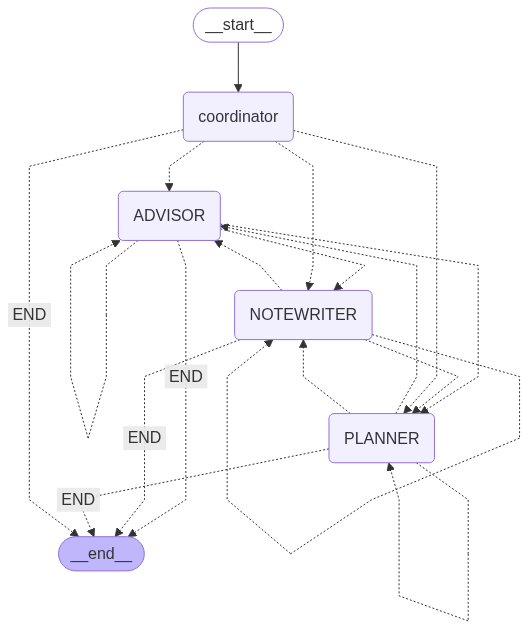

Bỏ qua thử nghiệm vì một hoặc nhiều thành phần chưa được khởi tạo.

In [36]:
# STEP 8 (PHIÊN BẢN NÂNG CẤP CUỐI CÙNG): LẮP RÁP TOÀN BỘ HỆ THỐNG
from typing import List, Literal
from langgraph.graph import StateGraph, END, START
from rich.panel import Panel
from IPython.display import Image, display

# --- Phần 1: Khởi tạo tất cả các thành phần ---
print("Bắt đầu lắp ráp Đồ thị chính ATLAS (Phiên bản Nâng cấp)...")

# DataManager đã được khởi tạo ở STEP 3 với google_calendar_service
# Chúng ta sẽ sử dụng lại biến `data_manager` đã có.

# Khởi tạo các Agent chuyên biệt
planner_agent = PlannerAgent(llm)

# =================================================================== #
#   ĐÂY LÀ ĐOẠN CODE KHỞI TẠO ĐÚNG CHO NOTEWRITERAGENT               #
# =================================================================== #
# Nó kiểm tra xem tavily_tool có tồn tại không trước khi khởi tạo.
if 'tavily_tool' in locals() and tavily_tool:
    notewriter_agent = NoteWriterAgent(llm, search_tool=tavily_tool)
else:
    notewriter_agent = None
    console.print("[bold red]Cảnh báo: Không thể khởi tạo NoteWriterAgent vì tavily_tool không có sẵn.[/bold red]")
# =================================================================== #

advisor_agent = AdvisorAgent(llm)

# Tạo các subgraph cho từng agent
planner_subgraph = planner_agent.create_subgraph()
if notewriter_agent:
    notewriter_subgraph = notewriter_agent.create_subgraph()
else:
    notewriter_subgraph = None
advisor_subgraph = advisor_agent.create_subgraph()

print("✅ Tất cả các thành phần đã được khởi tạo.")


# --- Phần 2: Thiết kế Router và Đồ thị chính (Giữ nguyên như phiên bản nâng cấp) ---
def router(state: AcademicState) -> Literal["PLANNER", "NOTEWRITER", "ADVISOR", "END"]:
    # ... (code router giữ nguyên)
    print("\n--- [Router] Đang quyết định luồng đi tiếp theo... ---")
    required_agents = state.get("results", {}).get("coordinator_analysis", {}).get("required_agents", [])
    completed_keys = state.get("results", {}).keys()
    if "PLANNER" in required_agents and "final_plan" not in completed_keys: return "PLANNER"
    if "NOTEWRITER" in required_agents and "final_notes" not in completed_keys:
        if notewriter_subgraph: return "NOTEWRITER"
    if "ADVISOR" in required_agents and "final_advice" not in completed_keys: return "ADVISOR"
    return "END"

workflow = StateGraph(AcademicState)
workflow.add_node("coordinator", coordinator_agent)
workflow.add_node("PLANNER", planner_subgraph)
if notewriter_subgraph: workflow.add_node("NOTEWRITER", notewriter_subgraph)
workflow.add_node("ADVISOR", advisor_subgraph)
workflow.set_entry_point("coordinator")
possible_routes = {"PLANNER": "PLANNER", "ADVISOR": "ADVISOR", "END": END}
if notewriter_subgraph: possible_routes["NOTEWRITER"] = "NOTEWRITER"
workflow.add_conditional_edges("coordinator", router, possible_routes)
workflow.add_conditional_edges("PLANNER", router, possible_routes)
if notewriter_subgraph: workflow.add_conditional_edges("NOTEWRITER", router, possible_routes)
workflow.add_conditional_edges("ADVISOR", router, possible_routes)
app = workflow.compile()
print("\n--- Đồ thị chính ATLAS (Phiên bản Nâng cấp) đã được biên dịch thành công! ---")
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Không thể tạo sơ đồ: {e}")

# --- Phần 3: Chạy Toàn bộ Hệ thống với Dữ liệu Live (Giữ nguyên như phiên bản nâng cấp) ---
async def run_full_system_live():
    # ... (code hàm chạy giữ nguyên)
    request_content = "Dựa vào lịch trình thực tế của tôi, hãy giúp tôi tạo một kế hoạch chi tiết cho tuần tới. Đồng thời, tôi cần tìm hiểu và tóm tắt về 'retrieval-augmented generation' (RAG)."
    console.print("\n" + "="*50, style="bold blue")
    console.print(" BẮT ĐẦU CHẠY HỆ THỐNG ATLAS (LIVE DATA)", style="bold blue")
    console.print(f"\n[bold]Yêu cầu người dùng:[/bold] {request_content}")
    live_calendar_data = {"events": data_manager.get_upcoming_events(days_ahead=7)}
    active_tasks_data = {"tasks": data_manager.get_active_tasks()}
    initial_state = {"messages": [HumanMessage(content=request_content)], "profile": data_manager.get_student_profile("student_123"), "calendar": live_calendar_data, "tasks": active_tasks_data, "results": {}}
    final_state = None
    async for step in app.astream(initial_state):
        node_name = list(step.keys())[0]
        console.print(f"\n✅ [bold magenta]Hoàn thành bước:[/] [yellow]{node_name}[/yellow]")
        final_state = step
    console.print("\n" + "="*50, style="bold green")
    console.print(" HỆ THỐNG ATLAS ĐÃ CHẠY XONG!", style="bold green")
    if final_state:
        results = list(final_state.values())[0]['results']
        console.print("\n\n--- KẾT QUẢ TỔNG HỢP ---")
        if 'final_plan' in results: console.print(Panel(Markdown(results['final_plan']['plan_text']), title="[bold green]Kế hoạch đề xuất[/bold green]", border_style="green"))
        if 'final_notes' in results: console.print(Panel(Markdown(results['final_notes']['notes_text']), title="[bold blue]Ghi chú Nghiên cứu[/bold blue]", border_style="blue"))
        if 'final_advice' in results: console.print(Panel(Markdown(results['final_advice']['advice_text']), title="[bold magenta]Lời khuyên chiến lược[/bold magenta]", border_style="magenta"))

# Chạy hệ thống
if all(v in locals() for v in ['llm', 'google_calendar_service', 'tavily_tool', 'data_manager']):
    await run_full_system_live()
else:
    console.print("[bold red]Bỏ qua thử nghiệm vì một hoặc nhiều thành phần chưa được khởi tạo.[/bold red]")